# 7_export_thalamus_data_for_cirrocumulus

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import numpy as np
import pandas as pd
import anndata as ad

import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

from thalamus_merfish_analysis import abc_load as abc
from thalamus_merfish_analysis import ccf_plots as cplots
# from thalamus_merfish_analysis import abc_to_cirro as a2c

get_ipython().run_line_magic('matplotlib', 'inline')

## Load abc atlas data

In [9]:
# load custom adata with required metadata for cirrocumulus compatibility
adata_th_zi = abc.load_adata_thalamus(flip_y=True, # invert y coords so sections appear in correct coronal orientation
                                      with_colors=False, # don't need colors per cell - can get them from dict
                                      ) 
# filter by class
adata_th_zi_neurons = abc.filter_by_class_thalamus(adata_th_zi,
                                                   filter_nonneuronal=True,
                                                   filter_midbrain=False,
                                                   filter_other_nonTH=True
                                                  )
# filter by thalamus coordinates
adata_th_zi_neurons = abc.filter_by_thalamus_coords(adata_th_zi_neurons, 
                                                    buffer=0
                                                    )

In [10]:
adata_th_zi_neurons

View of AnnData object with n_obs × n_vars = 79158 × 500
    obs: 'brain_section_label', 'average_correlation_score', 'class', 'class_color', 'cluster', 'cluster_alias', 'cluster_color', 'donor_genotype', 'donor_label', 'donor_sex', 'feature_matrix_label', 'left_hemisphere', 'neurotransmitter', 'neurotransmitter_color', 'parcellation_category', 'parcellation_category_color', 'parcellation_division', 'parcellation_division_color', 'parcellation_index', 'parcellation_organ', 'parcellation_organ_color', 'parcellation_structure', 'parcellation_structure_color', 'parcellation_substructure', 'parcellation_substructure_color', 'subclass', 'subclass_color', 'supertype', 'supertype_color', 'x_ccf', 'x_reconstructed', 'x_section', 'y_ccf', 'y_reconstructed', 'y_section', 'z_ccf', 'z_reconstructed', 'z_section'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'accessed_on', 'src', 'counts_transform'

In [12]:
# which columns in obs to use for plotting
realigned = False
if realigned:
    ccf_label = 'parcellation_substructure_realigned'
    coords = 'section'
else:
    ccf_label = 'parcellation_substructure'
    coords = 'reconstructed'
    
x_col = 'x_'+coords
y_col = 'y_'+coords
section_col = 'z_'+coords

sections_all = sorted(adata_th_zi_neurons.obs[section_col].unique())

In [49]:
def add_montage_coords(adata, 
                       section_col='z_section',
                       x_col='x_section',
                       y_col='y_section',
                       new_coord_suffix='_cirro',
                       n_cols=4):
    ''' Creates 2D montage spatial coordinates from 2D+section coordinates and 
    adds them to adata.obs.
    
    Montage spatial coordinates are used for simultaneous display of multiple 
    sections on a 2D screen, e.g. in cirrocumulus.

    Parameters
    ----------
    adata : AnnData object
        AnnData object with spatial data.
    section_col : str
        Column in adata.obs with section numbers.
    x_col, y_col : str
        Columns in adata.obs with x,y coordinates.
    new_coord_suffix : str
        Suffix to add to new x,y columns
    n_cols : int, default=4
        Number of columns to display sections in

    Returns
    -------
    adata : AnnData object
        with x & y montage spatial coordinates added to adata.obs
    '''

    # copy over original xy coords                 
    adata.obs['x'+new_coord_suffix] = adata.obs[x_col].copy()
    adata.obs['y'+new_coord_suffix] = adata.obs[y_col].copy()

    # Dynamically set x_shift, y_shift based on current x_col, y_col units
    width_max = abs(adata.obs[x_col].max() - adata.obs[x_col].min())
    height_max = abs(adata.obs[y_col].max() - adata.obs[y_col].min())
    # set x_shift and y_shift as a ratio of max width/height
    x_shift = width_max*1.2
    y_shift = -(height_max*1.5) # neg to start each new row below previous row

    sections = sorted(adata.obs[section_col].unique())
    count = 0
    # start with anterior-most section in top left and end with posterior-most 
    # section in bottom right
    for i, sec in enumerate(reversed(sections)):
        # increment x_shift each column; reset after completing a row
        curr_x_shift = x_shift * (count % n_cols)
        # increment y_shift after completing each row; 1st row has no y_shift
        curr_y_shift = y_shift * (i // n_cols)
        
        # apply x,y shifts to current section
        mask = adata.obs[section_col]==sec
        adata.obs.loc[mask, 'x'+new_coord_suffix] += curr_x_shift
        adata.obs.loc[mask, 'y'+new_coord_suffix] += curr_y_shift
        
        count+=1
    
    return adata

In [50]:
def add_coords_to_obsm(adata):
    ''' Copy cirro and CCF spatial coordinates into adata.obsm, where 
    cirrocumulus expects to find them. 
    
    3D CCF coords should be in .obs already from loading the ABC Atlas data.
    2D cirro coords should have been added to .obs with add_cirro_coords().
    '''

    if {'x_cirro','y_cirro'}.issubset(adata.obs.columns):
        adata.obsm['cirro_spatial'] = adata.obs[['x_cirro','y_cirro']].to_numpy()
    else:
        UserWarning("No cirrocumulus spatial coordinates, ['x_cirro','y_cirro'], found in adata.obs. Run add_cirro_coords() first.")


    if {'x_ccf','y_ccf','z_ccf'}.issubset(adata.obs.columns):
        adata.obsm['ccf_spatial_3d'] = adata.obs[['x_ccf','y_ccf','z_ccf']].to_numpy()
    else:
        UserWarning("No CCF spatial coordinates, ['x_ccf','y_ccf','z_ccf'], found in adata.obs.")

    return adata

In [51]:
adata_th_zi_neurons = add_cirro_coords(adata_th_zi_neurons, 
                                       section_col=section_col, 
                                       x_col=x_col, 
                                       y_col=y_col, 
                                       n_cols=4)

adata_th_zi_neurons = add_coords_to_obsm(adata_th_zi_neurons)

In [52]:
adata_th_zi_neurons

AnnData object with n_obs × n_vars = 79158 × 500
    obs: 'brain_section_label', 'average_correlation_score', 'class', 'class_color', 'cluster', 'cluster_alias', 'cluster_color', 'donor_genotype', 'donor_label', 'donor_sex', 'feature_matrix_label', 'left_hemisphere', 'neurotransmitter', 'neurotransmitter_color', 'parcellation_category', 'parcellation_category_color', 'parcellation_division', 'parcellation_division_color', 'parcellation_index', 'parcellation_organ', 'parcellation_organ_color', 'parcellation_structure', 'parcellation_structure_color', 'parcellation_substructure', 'parcellation_substructure_color', 'subclass', 'subclass_color', 'supertype', 'supertype_color', 'x_ccf', 'x_reconstructed', 'x_section', 'y_ccf', 'y_reconstructed', 'y_section', 'z_ccf', 'z_reconstructed', 'z_section', 'x_cirro_old', 'y_cirro_old', 'x_cirro', 'y_cirro'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'accessed_on', 'src', 'counts_transform'
    obsm: 'cirro_spatial', 'ccf_spatial', 'ccf

(1.4240606134342542, 30.370459222759962, -18.68667466054785, -3.69426669181421)

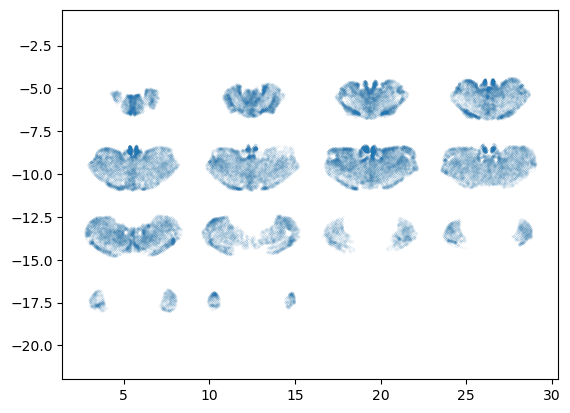

In [53]:
plt.scatter(adata_th_zi_neurons.obs['x_cirro'], adata_th_zi_neurons.obs['y_cirro'], s=0.001)
plt.axis('equal')

## Make color lists for .uns

.uns\["cluster_colors"\] should be a list of colors as hex strings (e.g. #D1C9BA)  in the order of the .obs.cluster.cat.categories

and same for .uns\["subclass_colors"\] matching the categories of .obs.subclass

In [71]:
def add_colors_to_uns(adata):
    ''' Add ABC color palette dict to adata.uns for each taxonomy level in 
    adata.obs.

    Cirrocumulus expects to find a dict mapping an adata.obs column's categories   
    to hex string colors stored in adata.uns. The dict keys MUST be in the order
    returned by adata.obs.my_column.cat.categories.
    e.g. if you want cirro to use custom colors for adata.obs['cluster'], then
    the color dict containining {category: color} should be stored in 
    adata.uns['cluster_colors'].

    Parameters
    ----------
    adata : AnnData object
        AnnData object with taxonomy levels in adata.obs.

    Returns
    -------
    adata : AnnData object
        with color palettes added to adata.uns for each taxonomy level in adata.obs.
    '''

    taxonomy_levels = ['class', 'subclass', 'supertype', 'cluster']
    assert set(taxonomy_levels).issubset(adata.obs.columns), f"adata.obs.columns is missing at least one of: {taxonomy_levels}"

    for level in taxonomy_levels:
        # get the full ABC color palette for this taxonomy level
        abc_color_dict = abc.get_taxonomy_palette(level)

        # get the categories that exist in this dataset
        # MUST be kept in the order returned by .cat.categories
        curr_cats = adata.obs[level].cat.categories

        # make new color dict for only the categories that exist in this dataset
        cat_color_dict = dict((cat, abc_color_dict[cat]) for cat in curr_cats if cat in abc_color_dict)

        # add this color dict to adata.uns
        adata.uns[level+'_colors'] = cat_color_dict
    
    return adata

In [72]:
adata_th_zi_neurons = add_colors_to_uns(adata_th_zi_neurons)
adata_th_zi_neurons

AnnData object with n_obs × n_vars = 79158 × 500
    obs: 'brain_section_label', 'average_correlation_score', 'class', 'class_color', 'cluster', 'cluster_alias', 'cluster_color', 'donor_genotype', 'donor_label', 'donor_sex', 'feature_matrix_label', 'left_hemisphere', 'neurotransmitter', 'neurotransmitter_color', 'parcellation_category', 'parcellation_category_color', 'parcellation_division', 'parcellation_division_color', 'parcellation_index', 'parcellation_organ', 'parcellation_organ_color', 'parcellation_structure', 'parcellation_structure_color', 'parcellation_substructure', 'parcellation_substructure_color', 'subclass', 'subclass_color', 'supertype', 'supertype_color', 'x_ccf', 'x_reconstructed', 'x_section', 'y_ccf', 'y_reconstructed', 'y_section', 'z_ccf', 'z_reconstructed', 'z_section', 'x_cirro_old', 'y_cirro_old', 'x_cirro', 'y_cirro'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'accessed_on', 'src', 'counts_transform', 'class_colors', 'subclass_colors', 'supertype

In [74]:
adata_th_zi_neurons.uns['class_colors']

{'12 HY GABA': '#FF6600',
 '19 MB Glut': '#007200',
 '20 MB GABA': '#9EF01A',
 '18 TH Glut': '#0D47A1',
 '17 MH-LH Glut': '#FAA307'}

## Generate UMAP, tSNE, etc.

/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


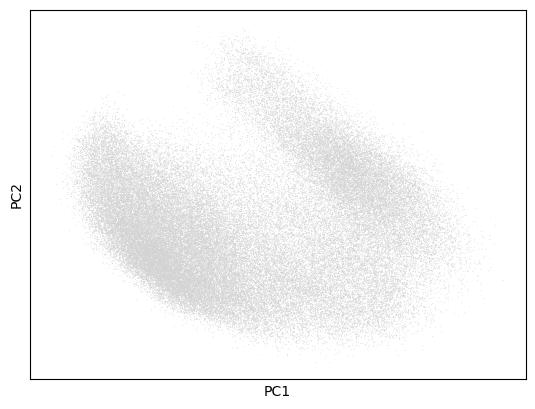

In [76]:
# PCA pre-processing
sc.pp.pca(adata_th_zi_neurons)
sc.pl.pca(adata_th_zi_neurons)

In [77]:
# more pre-processing
sc.pp.neighbors(adata_th_zi_neurons)

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


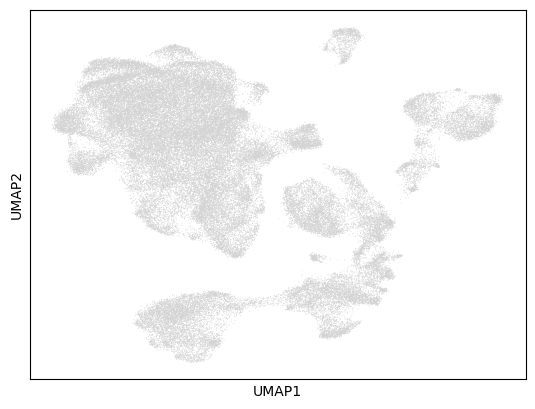

In [79]:
# UMAP
sc.tl.umap(adata_th_zi_neurons)
sc.pl.umap(adata_th_zi_neurons)

In [83]:
adata_th_zi_neurons

AnnData object with n_obs × n_vars = 79158 × 500
    obs: 'brain_section_label', 'average_correlation_score', 'class', 'class_color', 'cluster', 'cluster_alias', 'cluster_color', 'donor_genotype', 'donor_label', 'donor_sex', 'feature_matrix_label', 'left_hemisphere', 'neurotransmitter', 'neurotransmitter_color', 'parcellation_category', 'parcellation_category_color', 'parcellation_division', 'parcellation_division_color', 'parcellation_index', 'parcellation_organ', 'parcellation_organ_color', 'parcellation_structure', 'parcellation_structure_color', 'parcellation_substructure', 'parcellation_substructure_color', 'subclass', 'subclass_color', 'supertype', 'supertype_color', 'x_ccf', 'x_reconstructed', 'x_section', 'y_ccf', 'y_reconstructed', 'y_section', 'z_ccf', 'z_reconstructed', 'z_section', 'x_cirro_old', 'y_cirro_old', 'x_cirro', 'y_cirro'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'accessed_on', 'src', 'counts_transform', 'class_colors', 'subclass_colors', 'supertype

/opt/conda/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


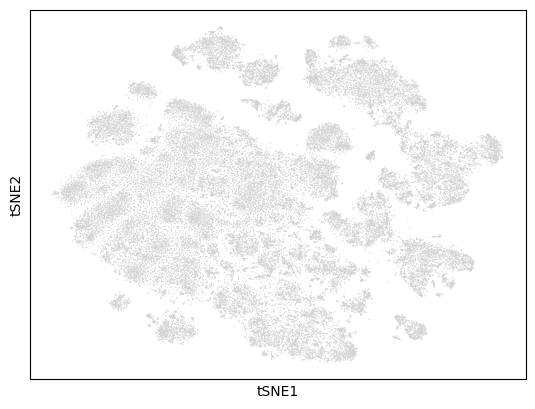

In [84]:
# tSNE - takes much longer than UMAP to run
sc.tl.tsne(adata_th_zi_neurons)
sc.pl.tsne(adata_th_zi_neurons)

In [91]:
adata_th_zi_neurons

AnnData object with n_obs × n_vars = 79158 × 500
    obs: 'brain_section_label', 'average_correlation_score', 'class', 'class_color', 'cluster', 'cluster_alias', 'cluster_color', 'donor_genotype', 'donor_label', 'donor_sex', 'feature_matrix_label', 'left_hemisphere', 'neurotransmitter', 'neurotransmitter_color', 'parcellation_category', 'parcellation_category_color', 'parcellation_division', 'parcellation_division_color', 'parcellation_index', 'parcellation_organ', 'parcellation_organ_color', 'parcellation_structure', 'parcellation_structure_color', 'parcellation_substructure', 'parcellation_substructure_color', 'subclass', 'subclass_color', 'supertype', 'supertype_color', 'x_ccf', 'x_reconstructed', 'x_section', 'y_ccf', 'y_reconstructed', 'y_section', 'z_ccf', 'z_reconstructed', 'z_section', 'x_cirro_old', 'y_cirro_old', 'x_cirro', 'y_cirro'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'accessed_on', 'src', 'counts_transform', 'class_colors', 'subclass_colors', 'supertype

In [85]:
adata_th_zi_neurons.obsm.pop('X_pca')
adata_th_zi_neurons.uns.pop('pca')
adata_th_zi_neurons.uns.pop('neighbors')
adata_th_zi_neurons.obsp.pop('connectivities')
adata_th_zi_neurons.obsp.pop('distances')
adata_th_zi_neurons.varm.pop('PCs')

<79158x79158 sparse matrix of type '<class 'numpy.float64'>'
	with 1108212 stored elements in Compressed Sparse Row format>

In [92]:
adata_th_zi_neurons

AnnData object with n_obs × n_vars = 79158 × 500
    obs: 'brain_section_label', 'average_correlation_score', 'class', 'class_color', 'cluster', 'cluster_alias', 'cluster_color', 'donor_genotype', 'donor_label', 'donor_sex', 'feature_matrix_label', 'left_hemisphere', 'neurotransmitter', 'neurotransmitter_color', 'parcellation_category', 'parcellation_category_color', 'parcellation_division', 'parcellation_division_color', 'parcellation_index', 'parcellation_organ', 'parcellation_organ_color', 'parcellation_structure', 'parcellation_structure_color', 'parcellation_substructure', 'parcellation_substructure_color', 'subclass', 'subclass_color', 'supertype', 'supertype_color', 'x_ccf', 'x_reconstructed', 'x_section', 'y_ccf', 'y_reconstructed', 'y_section', 'z_ccf', 'z_reconstructed', 'z_section', 'x_cirro_old', 'y_cirro_old', 'x_cirro', 'y_cirro'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'accessed_on', 'src', 'counts_transform', 'class_colors', 'subclass_colors', 'supertype

## Load & save SpaGCN domains results

In [104]:
# load in SpaGCN domain results
# temporarily a static file in '../code/resources' until I get a reproducible run setup for the spagcn capsule
spagcn_df = pd.read_parquet('/code/resources/spagcn_predicated_domains.parquet')
spagcn_df

,res1pt4,res1pt0,res0pt7
cell_label,,,
1018093344101120291-2,22,18,10
1018093344101120325-1,22,18,10
1018093344101110066-3,14,18,17
1018093344100960681-1,14,18,9
1018093344101110238-1,14,18,9
...,...,...,...
1018093345101610118-1,17,14,15
1018093345101620074,17,14,15
1018093345101450752-1,17,14,15


In [119]:
for col in spagcn_df.columns:
    spagcn_df[col] = pd.Categorical(spagcn_df[col], 
                                    categories=sorted(spagcn_df[col].unique()), 
                                    ordered=False)


In [122]:
spagcn_df['SpaGCN_domains']

cell_label
1018093344101120291-2    22
1018093344101120325-1    22
1018093344101110066-3    14
1018093344100960681-1    14
1018093344101110238-1    14
                         ..
1018093345101610118-1    17
1018093345101620074      17
1018093345101450752-1    17
1018093345101620252-1    17
1018093345101620505      17
Name: SpaGCN_domains, Length: 37683, dtype: category
Categories (30, int64): [0, 1, 2, 3, ..., 27, 29, 31, 32]

In [ ]:
adata_th_zi_neurons
adata_th_zi_neurons.obs = adata_th_zi_neurons.obs.join(spagcn_domains_df['SpaGCN_domains'], on='cell_label')

NameError: name 'spagcn_domains_df' is not defined

In [107]:
spagcn_df.rename(columns={'res1pt4':'SpaGCN_domains'},inplace=True)
spagcn_df['SpaGCN_domains']

cell_label
1018093344101120291-2    22
1018093344101120325-1    22
1018093344101110066-3    14
1018093344100960681-1    14
1018093344101110238-1    14
                         ..
1018093345101610118-1    17
1018093345101620074      17
1018093345101450752-1    17
1018093345101620252-1    17
1018093345101620505      17
Name: SpaGCN_domains, Length: 37683, dtype: category
Categories (30, int64): [0 < 1 < 2 < 3 ... 27 < 29 < 31 < 32]

In [110]:
adata_th_zi_neurons.obs = adata_th_zi_neurons.obs.join(spagcn_df['SpaGCN_domains'], on='cell_label')
adata_th_zi_neurons

AnnData object with n_obs × n_vars = 79158 × 500
    obs: 'brain_section_label', 'average_correlation_score', 'class', 'class_color', 'cluster', 'cluster_alias', 'cluster_color', 'donor_genotype', 'donor_label', 'donor_sex', 'feature_matrix_label', 'left_hemisphere', 'neurotransmitter', 'neurotransmitter_color', 'parcellation_category', 'parcellation_category_color', 'parcellation_division', 'parcellation_division_color', 'parcellation_index', 'parcellation_organ', 'parcellation_organ_color', 'parcellation_structure', 'parcellation_structure_color', 'parcellation_substructure', 'parcellation_substructure_color', 'subclass', 'subclass_color', 'supertype', 'supertype_color', 'x_ccf', 'x_reconstructed', 'x_section', 'y_ccf', 'y_reconstructed', 'y_section', 'z_ccf', 'z_reconstructed', 'z_section', 'x_cirro_old', 'y_cirro_old', 'x_cirro', 'y_cirro', 'SpaGCN_domains'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'accessed_on', 'src', 'counts_transform', 'class_colors', 'subclass_c

In [ ]:

adata_log2.obs['SpaGCN_domains'] = adata_log2.obs['SpaGCN_domains'].cat.add_categories('no data').fillna('no data')

adata_log2.obs['SpaGCN_domains']

In [115]:
adata_th_zi_neurons.obs['SpaGCN_domains'] = adata_th_zi_neurons.obs['SpaGCN_domains'].cat.add_categories('no data').fillna('no data')
adata_th_zi_neurons.obs['SpaGCN_domains']

cell_label
1018093344101100151-3    no data
1018093344101100117-3    no data
1018093344101100208-4    no data
1018093344101100158-4    no data
1018093344101100262-5    no data
                          ...   
1018093345101600622           22
1018093345101940289      no data
1018093345101600851            5
1018093345101950253-1    no data
1018093345101620505           17
Name: SpaGCN_domains, Length: 79158, dtype: category
Categories (31, object): [0 < 1 < 2 < 3 ... 29 < 31 < 32 < 'no data']

In [116]:
spg_domain_cats = adata_th_zi_neurons.obs['SpaGCN_domains'].cat.categories
print(f'{spg_domain_cats=}')
spg_palette_sns = sns.color_palette(cc.glasbey, n_colors=len(spg_domain_cats))

# set the 'no data' category color to white so it doesn't show up in cirro
spg_palette_sns[-1] = (1.0, 1.0, 1.0)

# need RGB dict for sns plotting to check colors
palette_dict_sns = dict(zip(spg_domain_cats, spg_palette_sns))

# need hex strings for cirro
spg_palette_cirro = list(spg_palette_sns.as_hex())
print(spg_palette_cirro)

spg_domain_cats=Index([        0,         1,         2,         3,         4,         5,
               6,         7,         8,         9,        11,        12,
              13,        14,        15,        16,        17,        18,
              19,        20,        21,        22,        23,        24,
              25,        26,        27,        29,        31,        32,
       'no data'],
      dtype='object')
['#d60000', '#8c3bff', '#018700', '#00acc6', '#97ff00', '#ff7ed1', '#6b004f', '#ffa52f', '#573b00', '#005659', '#0000dd', '#00fdcf', '#a17569', '#bcb6ff', '#95b577', '#bf03b8', '#645474', '#790000', '#0774d8', '#fdf490', '#004b00', '#8e7900', '#ff7266', '#edb8b8', '#5d7e66', '#9ae4ff', '#eb0077', '#a57bb8', '#5900a3', '#03c600', '#ffffff']


(1.4240606134342542, 30.370459222759962, -18.68667466054785, -3.69426669181421)

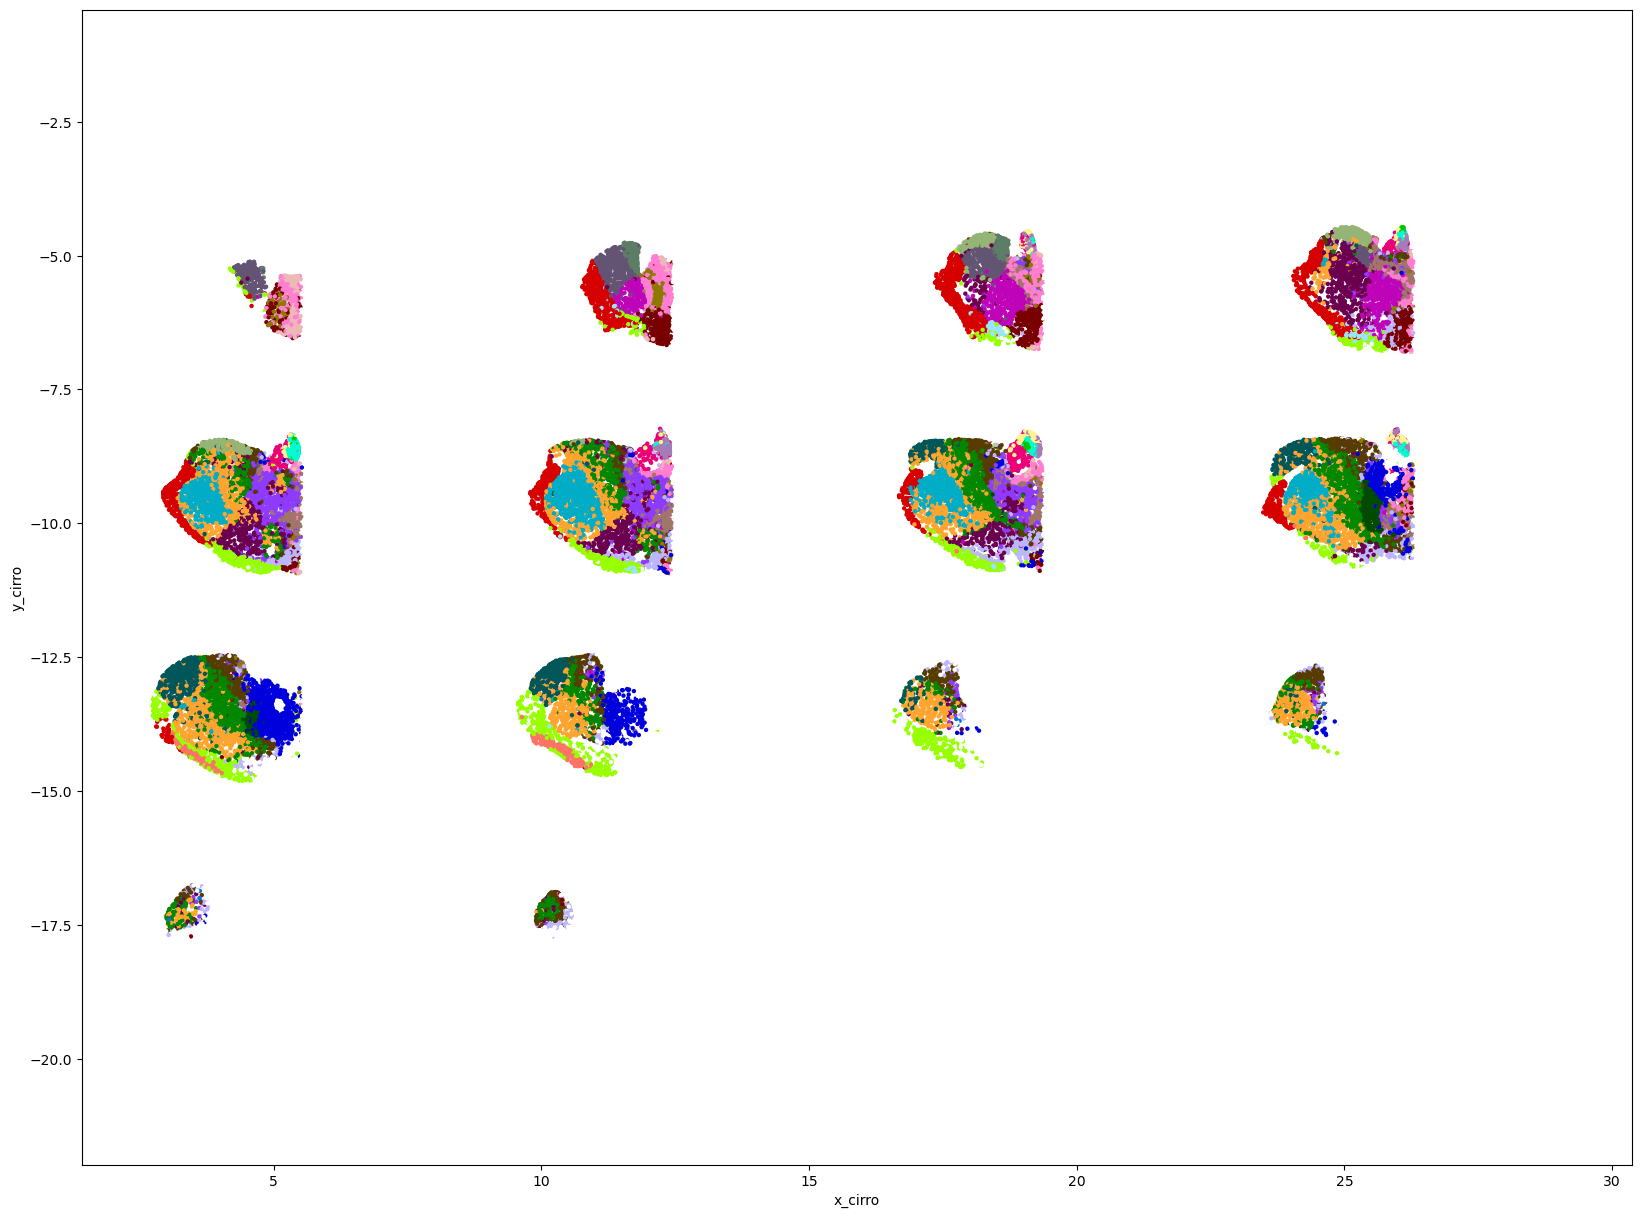

In [117]:
fig = plt.figure(figsize=(20,15))
ax = fig.gca()
sns.scatterplot(adata_th_zi_neurons.obs, ax=ax, x='x_cirro', y='y_cirro', 
                hue='SpaGCN_domains', s=10, palette=palette_dict_sns, 
                linewidth=0, legend=False)
plt.axis('equal')

In [118]:
adata_th_zi_neurons.obs['SpaGCN_domains']

cell_label
1018093344101100151-3    no data
1018093344101100117-3    no data
1018093344101100208-4    no data
1018093344101100158-4    no data
1018093344101100262-5    no data
                          ...   
1018093345101600622           22
1018093345101940289      no data
1018093345101600851            5
1018093345101950253-1    no data
1018093345101620505           17
Name: SpaGCN_domains, Length: 79158, dtype: category
Categories (31, object): [0 < 1 < 2 < 3 ... 29 < 31 < 32 < 'no data']

In [29]:
adata_log2.uns['SpaGCN_domains_color'] = spg_palette_cirro

# Load & save NSF results

In [30]:
adata_nsf = ad.read_zarr("/root/capsule/data/nsf_2000_adata/nsf_2000_adata.zarr")

In [31]:
nsf_cols = ['nsf_tot', 'nsf0', 'nsf1', 'nsf2', 'nsf3', 'nsf4', 
            'nsf5', 'nsf6', 'nsf7', 'nsf8', 'nsf9', 'nsf10', 
            'nsf11', 'nsf12', 'nsf13', 'nsf14', 'nsf15', 'nsf16', 
            'nsf17', 'nsf18', 'nsf19', 'nsf20', 'nsf21', 'nsf22', 
            'nsf23', 'nsf24', 'nsf25', 'nsf26', 'nsf27', 'nsf28', 
            'nsf29']
nsf_df = adata_nsf.obs[nsf_cols].copy()
nsf_df

,nsf_tot,nsf0,nsf1,nsf2,nsf3,nsf4,nsf5,nsf6,nsf7,nsf8,...,nsf20,nsf21,nsf22,nsf23,nsf24,nsf25,nsf26,nsf27,nsf28,nsf29
cell_label,,,,,,,,,,,,,,,,,,,,,
1018093344102490116-4,504.902679,0.001184,0.000319,0.001158,0.003675,0.770119,0.001990,0.027267,0.001629,0.016931,...,0.001601,0.010653,0.003671,0.000488,0.001222,0.001950,0.000532,0.004254,0.000996,0.003392
1018093345102320739,494.795776,0.015365,0.000634,0.007125,0.013677,0.000275,0.007691,0.000389,0.015648,0.107151,...,0.110615,0.002064,0.003663,0.151959,0.222681,0.003510,0.001856,0.006191,0.012567,0.008169
1018093344101520204-6,487.793732,0.026045,0.000822,0.048580,0.000441,0.270117,0.005557,0.012342,0.112307,0.008572,...,0.006474,0.090102,0.004248,0.066157,0.001970,0.006698,0.002039,0.048212,0.001087,0.012348
1017092617101780160-1,531.638306,0.000366,0.000196,0.006236,0.901865,0.001499,0.000668,0.000737,0.004919,0.001393,...,0.001839,0.000959,0.000668,0.000467,0.000941,0.000256,0.000215,0.001959,0.000713,0.006519
1018093344201340262,498.494690,0.104071,0.000644,0.058316,0.001962,0.002068,0.001664,0.000390,0.192760,0.015547,...,0.023974,0.003032,0.007294,0.231134,0.016147,0.000841,0.000552,0.018780,0.002022,0.006946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018093344101510543-2,472.823639,0.036379,0.000373,0.001226,0.000472,0.119669,0.000946,0.003140,0.000715,0.003028,...,0.005620,0.001160,0.000626,0.029157,0.002396,0.000213,0.000258,0.000756,0.000637,0.006960
1019171907102290212,488.520020,0.002556,0.000838,0.257155,0.001263,0.037019,0.001317,0.000456,0.070659,0.004755,...,0.005999,0.001817,0.003306,0.029245,0.005330,0.000888,0.001282,0.213882,0.152381,0.005006
1020131842101740715,524.911133,0.000935,0.000452,0.010906,0.000341,0.002124,0.009457,0.002084,0.001065,0.000569,...,0.000952,0.001363,0.001199,0.000296,0.013797,0.000365,0.000318,0.002206,0.007246,0.009137


In [32]:
adata_log2.obs = adata_log2.obs.join(nsf_df, on='cell_label')
adata_log2.obs.head(3)

,brain_section_label,average_correlation_score,class,cluster,cluster_alias,left_hemisphere,neurotransmitter,parcellation_division,parcellation_index,parcellation_structure,...,nsf20,nsf21,nsf22,nsf23,nsf24,nsf25,nsf26,nsf27,nsf28,nsf29
cell_label,,,,,,,,,,,,,,,,,,,,,
1018093344101120291-2,C57BL6J-638850.30,0.632058,18 TH Glut,2706 MG-POL-SGN Nts Glut_1,5027,True,Glut,TH,315,SGN,...,0.019085,0.006476,0.001565,0.001848,0.003526,0.003133,0.000942,0.022894,0.004984,0.003070
1018093344102320608-3,C57BL6J-638850.30,0.567402,18 TH Glut,2706 MG-POL-SGN Nts Glut_1,5027,False,Glut,TH,539,TH-unassigned,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1018093344101110157-4,C57BL6J-638850.30,0.552009,18 TH Glut,2706 MG-POL-SGN Nts Glut_1,5027,True,Glut,TH,315,SGN,...,0.049996,0.004473,0.001734,0.015428,0.023777,0.001602,0.000976,0.012069,0.006774,0.004423


In [33]:
adata_log2.obs[nsf_cols] = adata_log2.obs[nsf_cols].fillna(0)

In [34]:
adata_log2.obs.head(5)

,brain_section_label,average_correlation_score,class,cluster,cluster_alias,left_hemisphere,neurotransmitter,parcellation_division,parcellation_index,parcellation_structure,...,nsf20,nsf21,nsf22,nsf23,nsf24,nsf25,nsf26,nsf27,nsf28,nsf29
cell_label,,,,,,,,,,,,,,,,,,,,,
1018093344101120291-2,C57BL6J-638850.30,0.632058,18 TH Glut,2706 MG-POL-SGN Nts Glut_1,5027,True,Glut,TH,315,SGN,...,0.019085,0.006476,0.001565,0.001848,0.003526,0.003133,0.000942,0.022894,0.004984,0.003070
1018093344102320608-3,C57BL6J-638850.30,0.567402,18 TH Glut,2706 MG-POL-SGN Nts Glut_1,5027,False,Glut,TH,539,TH-unassigned,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1018093344101110157-4,C57BL6J-638850.30,0.552009,18 TH Glut,2706 MG-POL-SGN Nts Glut_1,5027,True,Glut,TH,315,SGN,...,0.049996,0.004473,0.001734,0.015428,0.023777,0.001602,0.000976,0.012069,0.006774,0.004423
1018093344101120104-2,C57BL6J-638850.30,0.509473,18 TH Glut,2706 MG-POL-SGN Nts Glut_1,5027,True,Glut,TH,315,SGN,...,0.123576,0.001483,0.002291,0.017997,0.048304,0.002693,0.001195,0.007884,0.015680,0.004474
1018093344102470221-3,C57BL6J-638850.30,0.619522,18 TH Glut,2706 MG-POL-SGN Nts Glut_1,5027,False,Glut,TH,1077,MG,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Clean up obs

In [35]:
cols_to_remove = ['parcellation_division', 'parcellation_index', 
                  # 'parcellation_structure','parcellation_substructure', 
                  'x_ccf', 'y_ccf', 'z_ccf', 'x_cirro', 'y_cirro']

adata_log2.obs.drop(columns=cols_to_remove, inplace=True)

## Save as h5ad

In [36]:
adata_log2

AnnData object with n_obs × n_vars = 74523 × 500
    obs: 'brain_section_label', 'average_correlation_score', 'class', 'cluster', 'cluster_alias', 'left_hemisphere', 'neurotransmitter', 'parcellation_structure', 'parcellation_substructure', 'subclass', 'supertype', 'x_reconstructed', 'x_section', 'y_reconstructed', 'y_section', 'z_reconstructed', 'z_section', 'SpaGCN_domains', 'nsf_tot', 'nsf0', 'nsf1', 'nsf2', 'nsf3', 'nsf4', 'nsf5', 'nsf6', 'nsf7', 'nsf8', 'nsf9', 'nsf10', 'nsf11', 'nsf12', 'nsf13', 'nsf14', 'nsf15', 'nsf16', 'nsf17', 'nsf18', 'nsf19', 'nsf20', 'nsf21', 'nsf22', 'nsf23', 'nsf24', 'nsf25', 'nsf26', 'nsf27', 'nsf28', 'nsf29'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'accessed_on', 'src', 'counts_transform', 'class_colors', 'subclass_colors', 'supertype_colors', 'cluster_colors', 'pca', 'neighbors', 'umap', 'tsne', 'SpaGCN_domains_color'
    obsm: 'cirro_spatial', 'ccf_spatial', 'X_pca', 'X_umap', 'X_tsne', 'X_umap_raw'
    varm: 'PCs'
    obsp: 'distance

In [39]:
adata_log2.write('/results/wmb_abc_atlas_v20230830_th_nsf_spagcn_for_cirro_log2CPM.h5ad', compression="gzip")

In [40]:
adata.write('/results/wmb_abc_atlas_v20230830_th_nsf_spagcn_for_cirro_raw.h5ad', compression="gzip")

In [41]:
adata_raw = adata_log2.copy()

In [42]:
adata_raw.X = adata.X.copy()

In [43]:
adata_raw.write('/results/wmb_abc_atlas_v20230830_th_nsf_spagcn_for_cirro_raw.h5ad', compression="gzip")

In [46]:
adata_MKlog2X = abc.load_adata_thalamus(version=version, 
                             transform='log2', # will manually norm+log2 later
                             subset_to_TH_ZI=True, 
                             with_metadata=False, 
                             flip_y=True,
                             round_z=True,
                             with_colors=False)

adata_MKlog2X_th_zi_neurons = abc.filter_by_class_thalamus(adata_MKlog2X, 
                                                           filter_nonneuronal=True,
                                                           filter_midbrain=True)

# filter to thalamus boundaries (add a buffer here if wanted)
filter_buffer = 0  # 5
realigned=False
obs_filtered_MKlog2X = abc.filter_by_thalamus_coords(adata_MKlog2X_th_zi_neurons.obs.copy(), 
                                             realigned=realigned, 
                                             buffer=filter_buffer)
adata_MKlog2X_th_zi_neurons = adata_MKlog2X_th_zi_neurons[obs_filtered_MKlog2X.index].copy()

gene_list = [gene for gene in adata_MKlog2X_th_zi_neurons.var_names if 'Blank' not in gene]
adata_MKlog2X_th_zi_neurons = adata_MKlog2X_th_zi_neurons[:,gene_list]

adata_MKlog2X_th_zi_neurons

View of AnnData object with n_obs × n_vars = 74523 × 500
    obs: 'brain_section_label', 'average_correlation_score', 'class', 'cluster', 'cluster_alias', 'left_hemisphere', 'neurotransmitter', 'parcellation_division', 'parcellation_index', 'parcellation_structure', 'parcellation_substructure', 'subclass', 'supertype', 'x_ccf', 'x_reconstructed', 'x_section', 'y_ccf', 'y_reconstructed', 'y_section', 'z_ccf', 'z_reconstructed', 'z_section'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'accessed_on', 'src', 'counts_transform'

In [47]:
adata_log2CPV = adata_log2.copy()
adata_log2CPV.X = adata_MKlog2X_th_zi_neurons.X.copy()

In [49]:
adata_log2CPV.obs.rename(columns={'SpaGCN_domains':'spagcn'},inplace=True)

In [51]:
adata_log2CPV.uns['spagcn_colors'] = adata_log2CPV.uns['SpaGCN_domains_color']

In [52]:
adata_log2CPV.write('/results/wmb_abc_atlas_v20230830_th_nsf_spagcn_for_cirro_log2CPV.h5ad', compression="gzip")